In [15]:
# import libs
import yfinance as yf
import pandas as pd
import numpy as np
import os
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta

In [16]:
# download the data

def download_stock_data(ticker_symbol):
    """
    Download stock data with error handling and validation
    """
    try:
        # Create ticker object and get history
        yticker = yf.Ticker(ticker_symbol)
        df = yticker.history(period='max')
        
        if df.empty:
            raise ValueError(f"No data downloaded for {ticker_symbol}")
            
        print(f"Downloaded {len(df)} days of {ticker_symbol} data")
        
        # Basic validation
        required_columns = ['Open', 'Close', 'Volume']
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")
            
        return df
    
    except Exception as e:
        print(f"Error downloading {ticker_symbol}: {str(e)}")
        return None

# Download QQQ data
ticker = "QQQ"
df = download_stock_data(ticker)

df.tail()

Downloaded 6514 days of QQQ data


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2025-01-23 00:00:00-05:00,529.039978,532.760010,528.450012,532.640015,23096600,0.0,0.0,0.0
2025-01-24 00:00:00-05:00,533.020020,533.789978,528.150024,529.630005,19878300,0.0,0.0,0.0
2025-01-27 00:00:00-05:00,511.000000,517.989990,510.149994,514.210022,60771700,0.0,0.0,0.0
2025-01-28 00:00:00-05:00,515.219971,523.000000,511.779999,521.809998,33194200,0.0,0.0,0.0
2025-01-29 00:00:00-05:00,522.460022,522.590027,516.900024,520.830017,26292700,0.0,0.0,0.0


In [17]:
# transform the data

if df is not None:
    # Add Date and Ticker columns
    df['Date'] = df.index
    df['Ticker'] = ticker
    
    # Generate features for historical prices
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Weekday'] = df.index.weekday
    
    # Calculate historical returns for different periods
    for i in [1, 3, 5, 30, 90, 365]:
        df[f'growth_{i}d'] = df['Close'] / df['Close'].shift(i)
    
    # Calculate future growth (3 days ahead)
    df['future_growth_3d'] = df['Close'].shift(-3) / df['Close']
    
    # Calculate 30-day rolling volatility (annualized)
    df['volatility'] = df['Close'].rolling(30).std() * np.sqrt(252)
    
    # Calculate moving averages
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    
    # Calculate YoY growth
    df['YoY_growth'] = (df['Close'] / df['Close'].shift(252)) - 1
    
    # # Save data to file
    # os.makedirs('data', exist_ok=True)
    # df.to_csv(f'data/{ticker}_data.csv')
    # print(f"Data saved to data/{ticker}_data.csv")

In [18]:
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Date,Ticker,...,growth_3d,growth_5d,growth_30d,growth_90d,growth_365d,future_growth_3d,volatility,MA20,MA50,YoY_growth
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-23 00:00:00-05:00,529.039978,532.760010,528.450012,532.640015,23096600,0.0,0.0,0.0,2025-01-23 00:00:00-05:00,QQQ,...,1.020892,1.030850,1.013332,1.128965,1.462139,0.979667,139.127686,518.696501,516.254091,0.270494
2025-01-24 00:00:00-05:00,533.020020,533.789978,528.150024,529.630005,19878300,0.0,0.0,0.0,2025-01-24 00:00:00-05:00,QQQ,...,1.009204,1.032256,1.015514,1.117578,1.451194,0.983385,141.546103,519.034502,516.580445,0.258093
2025-01-27 00:00:00-05:00,511.000000,517.989990,510.149994,514.210022,60771700,0.0,0.0,0.0,2025-01-27 00:00:00-05:00,QQQ,...,0.967451,0.985568,0.989319,1.089855,1.417983,NaN,142.840005,518.247002,516.604390,0.214724
2025-01-28 00:00:00-05:00,515.219971,523.000000,511.779999,521.809998,33194200,0.0,0.0,0.0,2025-01-28 00:00:00-05:00,QQQ,...,0.979667,0.994303,0.986284,1.105379,1.422972,NaN,140.681557,517.857503,516.798906,0.231174
2025-01-29 00:00:00-05:00,522.460022,522.590027,516.900024,520.830017,26292700,0.0,0.0,0.0,2025-01-29 00:00:00-05:00,QQQ,...,0.983385,0.979906,0.990826,1.108101,1.435533,NaN,139.828126,517.771004,516.987000,0.236226


In [19]:
# visualize
# with template=presentations for larger fonts 

# Create price chart with moving averages
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], name='Close', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df.index, y=df['MA20'], name='MA20', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=df.index, y=df['MA50'], name='MA50', line=dict(color='red')))
fig.update_layout(
        title=f'{ticker} Price with Moving Averages',
        yaxis_title='Price',
        template='presentation'
    )
fig.show()
    
# Create volume chart
fig_volume = px.bar(
        df,
        x=df.index,
        y='Volume',
        title=f'{ticker} Trading Volume'
)
fig_volume.update_layout(template='presentation')
fig_volume.show()
    
# Create YoY growth chart
fig_yoy = px.bar(
        df,
        x=df.index,
        y='YoY_growth',
        title=f'{ticker} Year-over-Year Growth',
        color='YoY_growth',
        color_continuous_scale=['red', 'green']
)
fig_yoy.update_layout(
    yaxis_title='YoY Growth %',
    template='presentation'
)
fig_yoy.show()

<Axes: >

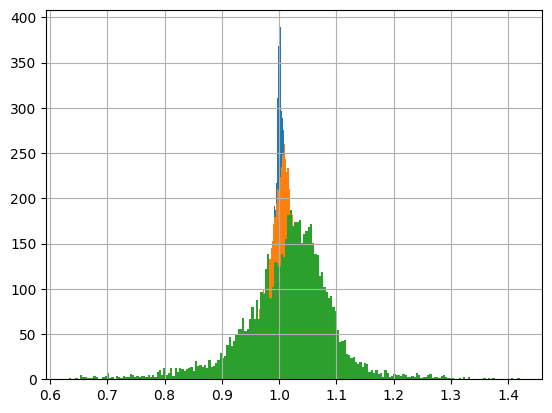

In [28]:
df.growth_1d.hist(bins=200)
df.growth_5d.hist(bins=200)
df.growth_30d.hist(bins=200)

In [29]:

# Reshaping Data for Plotly
df_melted = df[['growth_1d', 'growth_5d', 'growth_30d']].melt(var_name="Period", value_name="Growth")

# Create Histogram with Percent Formatting
fig = px.histogram(
    df_melted, 
    x="Growth", 
    color="Period", 
    barmode="overlay", 
    nbins=200, 
    histnorm="percent"  # Normalize to percentage
)

# Format Axes
fig.update_layout(
    xaxis=dict(tickformat=".0%"),  # Format x-axis as percentage
    yaxis=dict(title="Percentage of Total", tickformat=".1f%")  # Format y-axis as percentage
)

# Show figure
fig.update_layout(template='presentation')
fig.show()

In [ ]:
# Check the distribution shape - bet for 1week change (growth_5d)
df[['growth_1d', 'growth_5d', 'growth_30d']].describe().T

,count,mean,std,min,25%,50%,75%,max
growth_1d,6513.0,1.000528,0.017105,0.880212,0.993361,1.001134,1.008264,1.168421
growth_5d,6509.0,1.002532,0.034993,0.753810,0.985568,1.004955,1.020889,1.207195
growth_30d,6484.0,1.014911,0.082025,0.632387,0.976261,1.023092,1.061016,1.420028
